# Probabilistic Modeling

Probabilistic models are distributions over data.
The shape of the distribution is determine by model **parameters**.
Our goal to **estimate** or **infer** those parameters from observed data.

As the course goes on, we will encounter more and more complex datasets, and we will construct more and more sophisticated models.
However, our models will still be composed of just a handful of basic building blocks, and our central goal of parameter estimation and inference remains the same.

## Simple example

For example, let $x_t \in \mathbb{N}_0$ denote the number of spikes a neuron fires in time bin $t$. One of the simplest (and yet surprisingly not bad) models of neural spike counts is the [**Poisson distribution**](https://en.wikipedia.org/wiki/Poisson_distribution) with rate $\lambda \in \mathbb{R}_+$,

$$x_t \sim \mathrm{Pois}(\lambda).$$

The Poisson distribution has a simple **probability mass function (pmf)**,

$$\mathrm{Pois}(x_t; \lambda) = \frac{1}{x_t!} \lambda^{x_t} e^{-\lambda}.$$

For Poisson random variables, the **mean**, aka **expected value**, $\mathbb{E}[x_t]$, and **variance**, $\mathbb{V}[x_t]$, are both equal to $\lambda$.

:::{admonition} Notation
$x_t \in \mathbb{N}_0$ means that the variable $x_t$ is in ($\in$) the set $\mathbb{N}_0$, which is shorthand for the non-negative integers,

$$\mathbb{N}_0 = \{0,1,2,\ldots\}.$$

$\lambda \in \mathbb{R}_+$ means that the rate $\lambda$ is a non-negative real number.
:::

:::{admonition} Notation
The first equation says that the spike count $x_t$ is a **random variable** whose distribution is ($\sim$) Poisson with rate $\lambda$.

In the second equation, $\mathrm{Pois}(x_t; \lambda)$ refers to the pmf of the Poisson distribution evaluated at the point $x_t$. The notation can be a little confusing at first, but it's a standard convention.
:::

## Sampling from a Poisson distribution

Expand the code below to see how to sample a Poisson distribution using the `torch.distributions.Poisson` object in [PyTorch](https://pytorch.org/docs/stable/). The code plots the empirical distribution of 1000 independent samples from the Poisson distribution alongside the Poisson pmf.

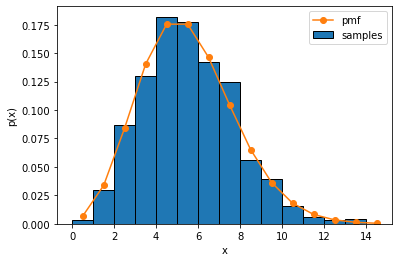

In [14]:
import torch
from torch.distributions import Poisson
import matplotlib.pyplot as plt

# Construct a Poisson distribution with rate 5.0 and draw 1000 samples
rate = 5.0
pois = Poisson(rate)
xs = pois.sample(sample_shape=(1000,))

# Plot a histogram of the samples and overlay the pmf
bins = torch.arange(15)
plt.hist(xs, bins, density=True, edgecolor='k', label='samples')
plt.plot(bins + .5, torch.exp(pois.log_prob(bins)), '-o', label='pmf')
plt.xlabel("x")
plt.ylabel("p(x)")
_ = plt.legend()

## Fitting a Poisson distribution

Now suppose you observe the empirical spike counts sampled above (i.e. the blue histogram) and you want to estimate the rate $\lambda$.

Let $\mathbf{x} = (x_1, \ldots, x_T)$ denote the vector of spike counts. 

Since the simulated spike counts are **independent** random variables, their **joint probability** is a product of Poisson pmf's,

$$
\begin{align*}
p(\mathbf{x}; \lambda) 
&= \prod_{t=1}^T p(x_t; \lambda) \\
&= \prod_{t=1}^T \mathrm{Pois}(x_t; \lambda) \\
&= \prod_{t=1}^T \frac{1}{x_t!} \lambda^{x_t} e^{-\lambda}.
\end{align*}
$$

We want to find the rate that maximizes this probability,

$$
\lambda_{\mathsf{MLE}} = \text{arg max} \; p(\mathbf{x}; \lambda).
$$

This is called **maximum likelihood estimation**, and $\lambda_{\mathsf{MLE}}$ is called the **maximum likelihood estimate (MLE)**.

## Solving for the MLE

In this simple model, we can derive a closed form expression for the MLE.

First, note that maximizing $p(\mathbf{x}; \lambda)$ is the same as maximizing $\log p(\mathbf{x}; \lambda)$, since the log is a concave function. 

Taking logs of both sides, we find

$$
\begin{align*}
\log p(\mathbf{x}; \lambda) 
&= \sum_{t=1}^T - \log x_t! + x_t \log \lambda -\lambda.
\end{align*}
$$

To maximize with respect to $\lambda$, we simply take the derivative, set it to zero, and solve for $\lambda$,

$$
\begin{align*}
\frac{\mathrm{d}}{\mathrm{d} \lambda} \log p(\mathbf{x}; \lambda) 
&= \sum_{t=1}^T \left( \frac{x_t}{\lambda} - 1 \right) \\
&= \frac{1}{\lambda} \left( \sum_{t=1}^T x_t \right) - T
\end{align*}
$$

Setting to zero and solving yields,

$$
\lambda_{\mathsf{MLE}} = \frac{1}{T} \sum_{t=1}^T x_t.
$$

In other words, the MLE is just the mean of the empirical spike counts, which seems sensible!

## Adding a prior distribution

Maximum likelihood estimation finds the rate that maximizes the probability of the observed spike counts, but it doesn't take into account any prior information.

For example, this may not be the first neuron you've ever encountered. Maybe, based on your experience, you have a sense for the distribution of neural firing rates. That knowledge can be encoded in a **prior distribution**. 

One common choice of prior on rates is the [**gamma distribution**](https://en.wikipedia.org/wiki/Gamma_distribution),

$$
\lambda \sim \mathrm{Ga}(\alpha, \beta).
$$

The gamma distribution has **support** for $\lambda \in \mathbb{R}_+$, and it is governed by two parameters:
- $\alpha$, the **shape** or **concentration** parameter, and
- $\beta$, the **inverse scale** or **rate** parameter.

It's **probability density function (pdf)** is,

$$
\mathrm{Ga}(\lambda; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

where $\Gamma(\cdot)$ denotes the gamma function.

:::{admonition} PDFs vs PMFs
:class: dropdown
Since the gamma distribution has _continuous_ support over the non-negative reals as opposed to _discrete_ support over, say, the non-negative integers, it has a probability _density_ function rather than a probability _mass_ function. 

Technically, the probability that $\lambda$ falls in a subset of $\mathbb{R}_+$, like the interval $[a, b)$, is the integral of the probability density function,

$$
\Pr(\lambda \in [a, b)) = \int_a^b \mathrm{Ga}(\lambda; \alpha, \beta) \, \mathrm{d} \lambda.
$$
:::

## Sampling from a gamma distribution

Expand the code below to see how to sample a gamma distribution using the [`torch.distributions.Gamma`](https://pytorch.org/docs/stable/distributions.html#gamma) object. The code plots the empirical distribution of 1000 independent samples from the gamma distribution, binned into 25 evenly sized bins. It overlays the gamma pdf for comparison.

In words, we might say this particular gamma distribution conveys a prior belief that
> _Firing rates are usually around 10 spikes/time bin with standard deviation of around 3 spikes/time bin._

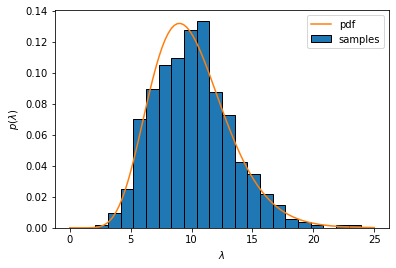

In [15]:
import torch
from torch.distributions import Gamma
import matplotlib.pyplot as plt

# Construct a gamma distribution 
alpha = 10.0
beta = 10.0/10.0
gam = Gamma(alpha, beta)
lambdas = gam.sample(sample_shape=(1000,))

# Plot a histogram of the samples and overlay the pmf
grid = torch.linspace(0, 25, 100)
bins = torch.linspace(0, 25, 25)
plt.hist(lambdas, bins, density=True, edgecolor='k', label='samples')
plt.plot(grid, torch.exp(gam.log_prob(grid)), '-', label='pdf')
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$p(\lambda)$")
_ = plt.legend()

## Fitting a Poisson distribution with a gamma prior

When we add in the prior distribution on $\lambda$, it becomes a random variable too. Now we have to consider the **joint distribution** of $\mathbf{x}$ and $\lambda$,

$$
\begin{align*}
p(\mathbf{x}, \lambda) 
&= p(\mathbf{x} \mid \lambda) \, p(\lambda) \\
&= \left[ \prod_{t=1}^T \mathrm{Pois}(x_t \mid \lambda) \right] \, \mathrm{Ga}(\lambda; \alpha, \beta) 
\end{align*}
$$

:::{warning}
We dropped the dependence on the parameters of the gamma prior, $\alpha$ and $\beta$. Technically, we should write $p(\mathbf{x}, \lambda; \alpha, \beta)$, but that gets cumbersome.
:::

:::{admonition} The Product Rule, the Sum Rule, and Bayes' Rule
In the first line we applied the **product rule** of probability, which says that we can rewrite a joint distribution as a product of a **marginal distribution** and a **conditional distribution**

$$
p(x, y) = p(x) \, p(y \mid x).
$$

The order doesn't matter; we could alternatively write,

$$
p(x, y) = p(y) p(x \mid y).
$$

The marginal distributions $p(x)$ and $p(y)$ are obtained via the **sum rule**,

$$
p(x) = \sum_{y \in \mathcal{Y}} p(x, y)
$$

where $\mathcal{Y}$ is the support of the random variable $y$. 

Finally, putting both together, we obtain **Bayes' rule**,

$$
p(x \mid y) = \frac{p(x, y)}{p(y)} = \frac{p(y \mid x) \, p(x)}{p(y)}.
$$
:::

:::{admonition} Bars vs semicolons
:class: dropdown
Why do we sometimes use bars ($\mid$) and other times semicolons (;)? 
Technically, we use the bar when we are writing a **conditional distribution** of one random variable given another, like $p(x \mid y)$ in Bayes' rule above. When we simply want to write a function that depends on some parameters, we use a semicolon, like $p(x; \theta)$.

So why did we switch from writing $p(\mathbf{x}; \lambda)$ to $p(\mathbf{x} \mid \lambda)$? Because when we placed a prior on $\lambda$, we switched from treating $\lambda$ as a parameter to instead thinking of it as a random variable. It's a technical distinction, but we'll try to be precise!

:::

## Bayesian inference

What does it mean to "fit" the rate of a Poisson distribution under a gamma prior? Formally, we perform **Bayesian inference**. 

We want to compute the **posterior distribution** of the rate $\lambda$ _given_ the observed spike counts $\mathbf{x}$ (and the prior parameters $\alpha$ and $\beta$, which are assumed fixed),

$$
p(\lambda \mid \mathbf{x}).
$$

By Bayes' rule (see box above), the posterior distribution is equal to the ratio of the **joint distribution** over the **marginal distribution**,

$$
p(\lambda \mid \mathbf{x}) = \frac{p(\mathbf{x}, \lambda)}{p(\mathbf{x})}.
$$

Note that the denominator (the marginal distribution) does not depend on $\lambda$, so the posterior is proportional to the joint,

$$
p(\lambda \mid \mathbf{x}) \propto p(\mathbf{x}, \lambda).
$$

## Maximum _a posteriori_ inference

A simple summary of the posterior distribution is its **mode** &mdash; the point(s) where the pdf is maximized,

$$
\lambda_{\mathsf{MAP}} = \text{arg max} \; p(\lambda \mid \mathbf{x}).
$$

or equivalently, 

$$
\lambda_{\mathsf{MAP}} = \text{arg max} \; p(\lambda, \mathbf{x}).
$$

since the posterior is proportional to the joint.

:::{warning}
True Bayesians cringe at MAP estimation! _How can a single point (the mode) summarize an entire distribution!?_ It can't, but we'll use it for now and be better Bayesians later in the course.
:::

## Conjugate priors

Now let's go back and expand the Poisson pmf and the gamma pdf in the joint distribution,

$$
\begin{align*}
p(\lambda \mid \mathbf{x}) & \propto p(\mathbf{x}, \lambda) \\
&= \left[ \prod_{t=1}^T \mathrm{Pois}(x_t \mid \lambda) \right] \, \mathrm{Ga}(\lambda; \alpha, \beta) \\
&= \left[ \prod_{t=1}^T \frac{1}{x_t!} \lambda^{x_t} e^{-\lambda} \right] \, \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}
\end{align*}
$$

Many of these terms can be combined! After simplifying, 

$$
\begin{align*}
p(\lambda \mid \mathbf{x}) 
& \propto p(\mathbf{x}, \lambda) \\
&= C \lambda^{\alpha' - 1} e^{-\beta' \lambda} \\
&\propto \mathrm{Ga}(\lambda \mid \alpha', \beta')
\end{align*}
$$

where 

$$
\begin{align*}
\alpha' &= \alpha + \sum_{t=1}^T x_t \\
\beta' &= \beta + T
\end{align*}
$$

and $C$ is a constant with respect to $\lambda$. 

Thus, the posterior distribution is a gamma distribution, just like the prior! For this reason, we say the gamma is a [**conjugate prior**](https://en.wikipedia.org/wiki/Conjugate_prior) for the rate of the Poisson distribution.


## Solving for the MAP estimate

How do we solve for the MAP estimate, $\lambda_{\mathsf{MAP}} = \text{arg max} \; p(\lambda \mid \mathbf{x})$?

Now that you know the posterior is a gamma distribution, you can expand its pdf, take the log, take the derivative wrt $\lambda$, set it to zero and solve. 

Or you can just go to the Wikipedia page on the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) and see that its mode is

$$
\lambda_{\mathsf{MAP}} = \frac{\alpha' - 1}{\beta'} = \frac{\alpha - 1 + \sum_{t=1}^T x_t}{\beta + T}
$$

for $\alpha' \geq 1$, and 0 otherwise. 

:::{admonition} Uninformative priors
:class: dropdown
When does the MAP estimate coincide with the MLE? Intuitively, that happens when the prior probability is flat, or **uninformative**. Unfortunately, it's impossible to have a flat prior over the entire set of non-negative reals since the pdf has to integrate to one. However, we obtain an uninformative gamma prior in the limit that $\alpha \to 1$ and $\beta \to 0$. In that limit, $\alpha' \to \sum_t x_t$ and $\beta' \to T$ so that $\lambda_{\mathsf{MAP}} \to \frac{1}{T} \sum_t x_t = \lambda_{\mathsf{MLE}}$.
:::

## MAP estimation in our simulated example

Take the simulated data from above. What is the MAP estimate of the rate given the observed spike counts and the prior, and how does it compare to the MLE? We have...

In [16]:
alpha_post = alpha + xs.sum()
beta_post = beta + len(xs)

lambda_mle = xs.sum() / len(xs)
lambda_map = (alpha_post - 1) / beta_post

print("MLE:", lambda_mle)
print("MAP:", lambda_map)

MLE: tensor(5.0480)
MAP: tensor(5.0519)


:::{admonition} Questions
- Why is the MAP estimate slightly higher than the MLE?
- What if you make $T$ smaller? Change the code above to sample $20$ spike counts instead of 1000. How does that change the MAP/MLE difference?
:::

## Mixture models and latent variables

:::{figure} images/02_probabilistic_modeling/up_down.png
---
name: up_down
---
Example of a mixture model with a latent variable $z_t$ specifying whether the neuron is in the up or down state.
:::

We've already gotten a lot of mileage out of this simple Poisson example! However, real data will rarely be so simple. One way to build richer models is by introducing **latent variables**.

For example, suppose that at each time bin $t$, the neuron can either be in an _up_ state with a high firing rate, or a _down_ state with low firing rate. 

Let $z_t \in \{0,1\}$ be a latent variable (something we don't explicitly observe) that denotes which state the neuron in is at that time, with 1 meaning _up_ and 0 meaning _down_. Likewise, let $\lambda_1$ and $\lambda_0$ denote the corresponding firing rates, with $\lambda_1 > \lambda_0$.

We will place gamma priors the firing rates, $\lambda_1 \sim \mathrm{Ga}(\alpha, \beta)$ and $\lambda_0 \sim \mathrm{Ga}(\alpha, \beta)$. (We could get fancy here, but let's keep it simple for now.)

Finally, assume that the latent variables are equally probable and independent across time. Formally, we can write that as a [**categorical distribution**](https://en.wikipedia.org/wiki/Categorical_distribution) with equal probabilities for both states,

$$
z_t \sim \mathrm{Cat}([\tfrac{1}{2}, \tfrac{1}{2}]).
$$

The resulting model is called a **mixture model** because the marginal distribution, $p(x_t \mid \boldsymbol{\lambda})$ where $\boldsymbol{\lambda} = (\lambda_0, \lambda_1)$, is a mixture of two Poisson distributions,

$$
\begin{align*}
p(x_t \mid \boldsymbol{\lambda}) 
&= \sum_{z_t \in \{0,1\}} p(x_t, z_t \mid \boldsymbol{\lambda}) \\
&= \sum_{z_t \in \{0,1\}} p(x_t \mid z_t, \boldsymbol{\lambda}) \, p(z_t) \\
&= \frac{1}{2} \mathrm{Pois}(x_t \mid \lambda_0) + \frac{1}{2} \mathrm{Pois}(x_t \mid \lambda_1) 
\end{align*}
$$

:::{admonition} Question
What probability rule did we use to get this marginal distribution?
:::

## Sampling a Poisson mixture model

Let's draw samples from the mixture model, like we did above for the single Poisson distribution.

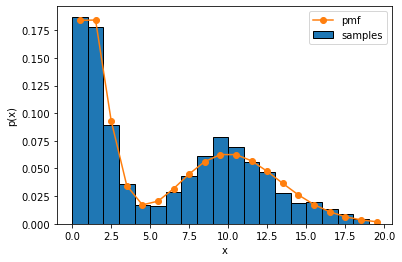

In [8]:
import torch
from torch.distributions import Poisson, Categorical
import matplotlib.pyplot as plt

# Construct a Poisson mixture model with down rate 1.0 and up rate 10.0
rates = torch.asarray([1.0, 10.0])
cat = Categorical(torch.asarray([0.5, 0.5]))
T = 1000

# Sample the states from the categorical distribution
zs = cat.sample(sample_shape=(T,))

# Sample the spike counts from a Poisson distribution 
# using the rate for the corresponding state.
# Note: this uses PyTorch's broadcasting semantics.
xs = Poisson(rates[zs]).sample()

# Compute the mixture probability at a range of bins
bins = torch.arange(20) 
up_pmf = torch.exp(Poisson(rates[1]).log_prob(bins))
down_pmf = torch.exp(Poisson(rates[0]).log_prob(bins))
mixture_pmf = 0.5 * (up_pmf + down_pmf)

# Plot a histogram of the samples and overlay the pmf
plt.hist(xs, bins, density=True, edgecolor='k', label='samples')
plt.plot(bins + 0.5, mixture_pmf, '-o', label='pmf')
plt.xlabel("x")
plt.ylabel("p(x)")
_ = plt.legend()

With this model, we can capture **multimodal** firing rate distributions.

:::{admonition} The `MixtureSameFamily` class
:class: dropdown
We manually sampled the mixture distribution by first sampling the `Categorical` and then the `Poisson`. PyTorch also provides a [`MixtureSameFamily`](https://pytorch.org/docs/stable/distributions.html#mixturesamefamily) class to do this in one step.
:::

## Fitting a mixture model by coordinate ascent

Conceptually, fitting the mixture model is no different than fitting the the simple Poisson model above.

We will perform MAP estimation to find,

$$
\begin{align*}
\mathbf{z}_{\mathsf{MAP}}, \boldsymbol{\lambda}_{\mathsf{MAP}}
= \text{arg max} \; p(\mathbf{z}, \boldsymbol{\lambda} \mid \mathbf{x})
\end{align*}
$$

where $\mathbf{z} = (z_1, \ldots, z_T)$. Again, this is equivalent to maximizing the joint probability.

Expanding the joint distribution over spike counts, latent variables, and rates,

$$
\begin{align*}
p(\mathbf{x}, \mathbf{z}, \boldsymbol{\lambda})
&= \left[ \prod_{t=1}^T p(x_t \mid z_t, \boldsymbol{\lambda}) \, p(z_t) \right]
p(\boldsymbol{\lambda})  \\
&= \left[ \prod_{t=1}^T \mathrm{Pois}(x_t \mid \lambda_{z_t}) \times \frac{1}{2} \right] \, \mathrm{Ga}(\lambda_0; \alpha, \beta) \, \mathrm{Ga}(\lambda_1; \alpha, \beta)
\end{align*}
$$

Our strategy for maximizing this objective is to iteratively maximize with respect to one variable at a time, holding the rest fixed. This is called **coordinate ascent**. 

Fixing the rates, the most likely state at time $t$ is,

$$
z_t = 
\begin{cases} 
1 & \text{if } \; \mathrm{Pois}(x_t \mid \lambda_1) \geq \mathrm{Pois}(x_t \mid \lambda_0) \\
0 & \text{otherwise}
\end{cases}
$$

Fixing the states, the most likely rates are

$$
\begin{align*}
\lambda_k &= \frac{\alpha_k' -1}{\beta_k'} \\
\alpha_k' &= \alpha + \sum_{t=1}^T x_t \, \mathbb{I}[z_t = k] \\
\beta_k' &= \beta + \sum_{t=1}^T \mathbb{I}[z_t = k]
\end{align*}
$$

for $k \in \{0, 1\}$. 

:::{admonition} Notation
The indicator function $\mathbb{I}[y]$ equals 1 if the predicate $y$ is true; otherwise it equals zero.
:::

:::{admonition} Exercise
Derive these coordinate updates!

How would they change if the state were not equally probable _a priori_? That is, what if instead

$$
z_t \sim \mathrm{Cat}([\pi_0, \pi_1])
$$

where $\pi_0$ and $\pi_1$ are the probabilities of down and up states, respectively?
:::

:::{admonition} Connection to K-Means
:class: dropdown
You may have encountered the K-Means clustering algorithm in other courses. In K-Means, you alternate between assining datapoints to the closest cluster and then updating the cluster centroids to the mean of their assigned datapoints. 

Our coordinate ascent algorithm is very closely related! You can think of K-Means as coordinate ascent in a Gaussian mixture model with identity covariance and uninformative priors. That will make more sense in later weeks when we introduce the Gaussian distribution.
:::




## Conclusion

This chapter introduced the basics of probabilistic modeling:
- We encountered 3 common distributions: Poisson, gamma, and categorical.
- We learned how to construct joint distributions using the product rule, how to compute marginal distributions with the sum rule, and how to find the posterior distribution with Bayes' rule.
- We learned about maximum likelihood estimation (MLE) and maximum _a posteriori_ (MAP) estimation. 
- We encountered conjugate priors where the posterior distribution is in the same family, making calculations particularly simple.
- Finally, we learned how to construct more flexible models by introducing latent variables, and how to perform MAP estimation in those models using coordinate ascent.

Next time, we'll apply these concepts to our first real neural data analysis problem: spike sorting electrophysiological recordings. 

## Further Reading

There are many great references on probabilistic modeling. I like:

- Ch 2.1 and 2.2 of {cite}`murphy2023probabilistic`
- Ch 1.2 of {cite}`bishop2006pattern`

## References
```{bibliography}
```